<a href="https://colab.research.google.com/github/freemind988/WANG/blob/master/Spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spaceship Titanic LGBM**

In [1]:
## 授權google drive
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **讀取資料**

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# data Loading
train = pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/spaceship_titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/spaceship_titanic/test.csv")
test_ids = test["PassengerId"]

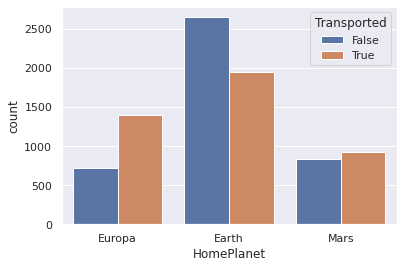

In [3]:
sns.set_theme(style="darkgrid")
sns.countplot(data=train, x="HomePlanet", hue="Transported")
plt.show()

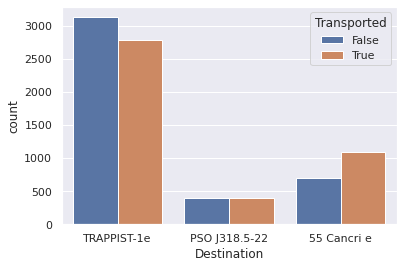

In [4]:
sns.set_theme(style="darkgrid")
sns.countplot(data=train, x="Destination", hue="Transported")
plt.show()

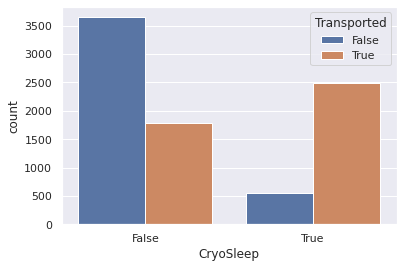

In [5]:
sns.set_theme(style="darkgrid")
sns.countplot(data=train, x="CryoSleep", hue="Transported")
plt.show()

In [6]:
X = train.iloc[:, 1:]
Y = train.iloc[:, 0]
print(f"train data shape: {X.shape}")
print(f"test data shape: {test.shape}")

train data shape: (8693, 13)
test data shape: (4277, 13)


In [7]:
# 資料整理
# data preparation 01
groups_train = {}
for value in train["PassengerId"].str.split("_").str[0]:
  groups_train[value] = groups_train.get(value, 0) + 1 

groups_test = {}
for value in test["PassengerId"].str.split("_").str[0]:
  groups_test[value] = groups_test.get(value, 0) + 1 


# data preparation 02
train_number = []
for index, value in train["PassengerId"].items():
  train_number.append(groups_train[value.split("_")[0]])

test_number = []
for index, value in test["PassengerId"].items():
  test_number.append(groups_test[value.split("_")[0]])

train["GroupSize"] = train_number
test["GroupSize"] = test_number

train[["Deck","Num","Side"]] = train["Cabin"].str.split("/",expand=True)
test[["Deck","Num","Side"]] = test["Cabin"].str.split("/",expand=True)

train.drop(["PassengerId","Cabin","Name"], axis=1, inplace=True)
test.drop(["PassengerId","Cabin","Name"], axis=1, inplace=True)


In [9]:
# data preparation 03
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP"]
for col in cat_cols:
  train[col].fillna(train[col].mode()[0], inplace=True)
  test[col].fillna(test[col].mode()[0], inplace=True)

num_cols = ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
for col in num_cols:
  train[col].fillna(train[col].mean(), inplace=True)
  test[col].fillna(test[col].mean(), inplace=True)


d = {"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6,"T":7}
train["Deck"].replace(d, inplace=True)
test["Deck"].replace(d, inplace=True)
train["Num"]= train["Num"].astype(float)
test["Num"]= test["Num"].astype(float)
train = pd.get_dummies(train, prefix_sep="_")
test = pd.get_dummies(train, prefix_sep="_")

y= train["Transported"]
X=train.drop(["Transported"], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, random_state = 42)



In [10]:
# train.head(5)
# test.head(5)
X.head(5)
# train.info()
# test.info()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,Deck,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0,1,0,0,0,1,1,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,1,5.0,0.0,1,0,0,0,0,1,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,2,0.0,0.0,0,1,0,0,0,1,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,2,0.0,0.0,0,1,0,0,0,1,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1,5.0,1.0,1,0,0,0,0,1,0,1


In [11]:
!pip install lightgbm --upgrade --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **標準化數據**

In [12]:
X= train.drop(["Transported"], axis=1)
y= train["Transported"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, random_state = 10)

In [13]:
y

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
mask = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
scaler = StandardScaler()
scaler.fit(train[mask])
train[mask] = scaler.transform(train[mask])
train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Deck,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Side_P,Side_S
0,False,0.709437,False,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,False,1,1.0,0.0,0,1,0,0,0,1,1,0
1,False,-0.336717,False,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,True,1,5.0,0.0,1,0,0,0,0,1,0,1
2,False,2.034566,True,-0.275409,1.955616,-0.290817,5.694289,-0.225782,False,2,0.0,0.0,0,1,0,0,0,1,0,1
3,False,0.290975,False,-0.340590,0.517406,0.330225,2.683471,-0.098708,False,2,0.0,0.0,0,1,0,0,0,1,0,1
4,False,-0.894666,False,0.118709,-0.243409,-0.038048,0.225732,-0.267258,True,1,5.0,1.0,1,0,0,0,0,1,0,1


## **搭建模型**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [18]:
# TRAINING
clf= LGBMClassifier(objective="binary",
           learning_rate=0.005,
           n_estimators=200,
           num_iterations=700,
           bagging_fraction=0.8,
           max_depth = -1,
            )
callbacks = [log_evaluation(period=50), early_stopping(stopping_rounds=50)]

clf.fit(X_train, y_train,
    eval_set= [(X_train, y_train),(X_val, y_val)],
    eval_names= ["train","val"],    
    eval_metric= "auc",
    callbacks= callbacks
    )

#TESTING
from sklearn.metrics import accuracy_score

test_pred = clf.predict(X_test)
print("accuracy:", accuracy_score(y_test, test_pred))


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.885734	train's binary_logloss: 0.601848	val's auc: 0.868968	val's binary_logloss: 0.607536
[100]	train's auc: 0.895074	train's binary_logloss: 0.541169	val's auc: 0.876029	val's binary_logloss: 0.551678
[150]	train's auc: 0.90074	train's binary_logloss: 0.497843	val's auc: 0.877897	val's binary_logloss: 0.513589
[200]	train's auc: 0.904257	train's binary_logloss: 0.466362	val's auc: 0.880715	val's binary_logloss: 0.486498
[250]	train's auc: 0.908865	train's binary_logloss: 0.441826	val's auc: 0.884699	val's binary_logloss: 0.4654
[300]	train's auc: 0.913013	train's binary_logloss: 0.421599	val's auc: 0.888197	val's binary_logloss: 0.44826
[350]	train's auc: 0.916331	train's binary_logloss: 0.405681	val's auc: 0.890235	val's binary_logloss: 0.435546
[400]	train's auc: 0.919107	train's binary_

## **測試資料產出最終數據**

In [24]:
# print(test_pred)
# submit
sol= pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/spaceship_titanic/sample_submission.csv")
sol.head()
# submission = clf.predict(test_pred)
# sol["Transported"] = clf.predict(test_pred).astype(bool)
test_pred = clf.predict(X_test)
# sol.to_csv("./submission.csv", index=False)
# test_pred.head()
print(test_pred)

[False  True False  True False False  True  True False False  True  True
 False  True  True False False False False  True False False  True False
  True  True False False  True False False  True  True False  True  True
 False  True False False False False  True  True False False False  True
 False  True False  True False  True  True  True  True False False False
  True  True  True False  True  True False  True False False  True False
 False  True False  True  True  True False False  True False  True  True
  True  True  True  True  True False  True  True  True  True  True False
  True False  True False False  True False False  True False  True  True
  True  True False  True  True  True  True False False  True  True False
  True False  True False False  True  True False  True False  True False
  True False  True False False  True False  True  True False False False
  True  True  True False False  True False False  True  True False  True
  True False False  True  True  True False False  T

In [44]:
ps_id = sol['PassengerId']
print(ps_id)

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object


In [48]:
output = pd.DataFrame({'PassengerId': sol.PassengerId,  'Transported': test_pred.astype('bool')})
output.to_csv('submission.csv', index=False)